**MOUNT TO DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**LOAD LIBRARIES FOR DATA**

In [2]:
import pandas as pd
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from matplotlib import pyplot

import string
from nltk.corpus import stopwords
nltk.download('stopwords')

plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

from sklearn.model_selection import cross_val_score
import numpy as np
!pip install lime
from lime import lime_tabular
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

from tensorflow.keras.layers import Dense, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 275 kB 13.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=985805743051250152a6d6d25fe4020a6f716d047105cfb0049b65737017f41d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


**READ THE DATA (TWEETS) FROM .CSV FILE**

In [3]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FNLP_CTASK/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**DESCRIBING THE DATASET- Exploratory Data Analysis (EDA)**

*Below shows the distribution of the data labels, where a value of 0 indicates Non-Disaster and 1 indicates Disaster*

In [4]:
# Obtain the types of classes available
tweet_class = df['target']
tweet_class.unique()

array([1, 0])

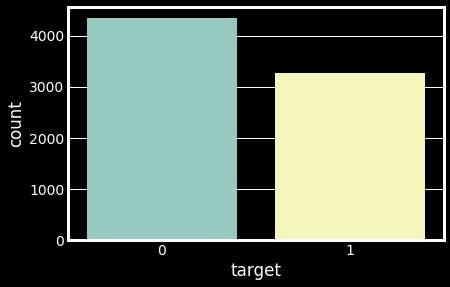

In [5]:
# Plot out how many of each class of tweet there is
ax = sns.countplot(x=tweet_class, data=df)

# It is observed that there are much more non-disaster tweets than disaster ones

**PREPROCESSING THE DATA- CLEANING: REMOVAL OF STOPWORDS AND PUNCTUATION**

*The tweets need to undergo cleaning prior to tokenization*

In [6]:
# Function that processes the text to remove punctuation and stopwords
def text_process_nopunc(msg):
  nopunc = [char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])
  # ^ disregards the stopwords (thus removing it) and only joins together the non-stopwords


# Function that processes the text to remove numbers
# source: https://stackoverflow.com/questions/12851791/removing-numbers-from-string
def text_process_nonumb(msg):
    nonumb = ''.join([char for char in msg if not char.isdigit()])
    return ' '.join([word for word in nonumb.split() if word.lower() not in stopwords.words('english')])

In [7]:
tweet_collection = df['text']

cleaned_tweets = []

# Tweet cleaning
for eachtweet in tweet_collection:
    eachtweet = eachtweet.lower() # convert each word to lowercase
    eachtweet = text_process_nonumb(eachtweet) # removes number
    eachtweet = text_process_nopunc(eachtweet) # removes punctuation
    cleaned_tweets.append(eachtweet)

In [8]:
cleaned_tweets

['deeds reason earthquake may allah forgive us',
 'forest fire near la ronge sask canada',
 'residents asked shelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school',
 'rockyfire update california hwy closed directions due lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
 'im top hill see fire woods',
 'theres emergency evacuation happening building across street',
 'im afraid tornado coming area',
 'three people died heat wave far',
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding',
 'raining flooding florida tampabay tampa days ive lost count',
 'flood bago myanmar arrived bago',
 'damage school bus multi car crash breaking',
 'whats man',
 'love fruits',
 'summer lovely',
 'car fast',
 'goooooooaaaaaal',
 'ridiculous',
 'london c

In [9]:
# Showing the new dataframe with cleaned tweets
df_processed = df
df_processed['text'] = cleaned_tweets

df_processed

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,NaN,NaN,utckm volcano hawaii httptcozdtoydebj,1
7611,10872,NaN,NaN,police investigating ebike collided car little...,1


**PREPARATION OF TWEETS AND THEIR CLASSES**

*The tweets and their classes are extracted and made into a format ready for tokenization and word vectorization later*

In [10]:
tweetclass = df_processed['target'].tolist()
cleanedtweet = df_processed['text'].tolist()

In [11]:
newdataset = []
n =  0

# Put together the tweet and its class
for item in tweetclass:
  newtuple = (tweetclass[n], cleanedtweet[n])
  newdataset.append(newtuple)
  n = n+1

newdataset

[(1, 'deeds reason earthquake may allah forgive us'),
 (1, 'forest fire near la ronge sask canada'),
 (1,
  'residents asked shelter place notified officers evacuation shelter place orders expected'),
 (1, 'people receive wildfires evacuation orders california'),
 (1, 'got sent photo ruby alaska smoke wildfires pours school'),
 (1,
  'rockyfire update california hwy closed directions due lake county fire cafire wildfires'),
 (1,
  'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas'),
 (1, 'im top hill see fire woods'),
 (1, 'theres emergency evacuation happening building across street'),
 (1, 'im afraid tornado coming area'),
 (1, 'three people died heat wave far'),
 (1,
  'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding'),
 (1, 'raining flooding florida tampabay tampa days ive lost count'),
 (1, 'flood bago myanmar arrived bago'),
 (1, 'damage school bus multi car crash breaking'),
 (0, 'whats man'),
 (0,

**NEXT UP: TOKENIZATION AND WORD VECTORIZATION**

*Downloading and installing the required libraries*

In [12]:
# From the nlpia package for downloading data too big for the repo

BIG_URLS = {
    'w2v': (
        'https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1',
        1647046227,
    ),
    'slang': (
        'https://www.dropbox.com/s/43c22018fbfzypd/slang.csv.gz?dl=1',
        117633024,
    ),
    'tweets': (
        'https://www.dropbox.com/s/5gpb43c494mc8p0/tweets.csv.gz?dl=1',
        311725313,
    ),
    'lsa_tweets': (
        'https://www.dropbox.com/s/rpjt0d060t4n1mr/lsa_tweets_5589798_2003588x200.tar.gz?dl=1',
        3112841563,  # 3112841312,
    ),
    'imdb': (
        'https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1',
        3112841563,  # 3112841312,
    ),
}

In [13]:
!pip install pugnlp

     |████████████████████████████████| 706 kB 13.3 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 23.2 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pypandoc: filename=pypandoc-1.7.5-py2.py3-none-any.whl size=23503245 sha256=30db4c714479d602458695dd2cb69f87918fcc2d53b05b8e3b3b855879464e87
  Stored in directory: /root/.cache/pip/wheels/df/fc/e9/4e92342cc30e3b25f26f37fca8b9bcd3f847f51a41ed01f122
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149871 sha256=e4af35ab87a48f4ad4508373b5c92e701b8dfcab22a825e0d0fd9e943bb951b2
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built pypandoc python-Levenshtein


In [14]:
import os
import re
import tarfile
import tqdm

import requests

from pugnlp.futil import path_status, find_files

# These functions are part of the nlpia package which can be pip installed and run from there.
def dropbox_basename(url):
    filename = os.path.basename(url)
    match = re.findall(r'\?dl=[0-9]$', filename)
    if match:
        return filename[:-len(match[0])]
    return filename

def download_file(url, data_path='.', filename=None, size=None, chunk_size=4096, verbose=True):
    """Uses stream=True and a reasonable chunk size to be able to download large (GB) files over https"""
    if filename is None:
        filename = dropbox_basename(url)
    file_path = os.path.join(data_path, filename)
    if url.endswith('?dl=0'):
        url = url[:-1] + '1'  # noninteractive download
    if verbose:
        tqdm_prog = tqdm
        print('requesting URL: {}'.format(url))
    else:
        tqdm_prog = no_tqdm
    r = requests.get(url, stream=True, allow_redirects=True)
    size = r.headers.get('Content-Length', None) if size is None else size
    print('remote size: {}'.format(size))

    stat = path_status(file_path)
    print('local size: {}'.format(stat.get('size', None)))
    if stat['type'] == 'file' and stat['size'] == size:  # TODO: check md5 or get the right size of remote file
        r.close()
        return file_path

    print('Downloading to {}'.format(file_path))

    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:  # filter out keep-alive chunks
                f.write(chunk)

    r.close()
    return file_path

def untar(fname):
    if fname.endswith("tar.gz"):
        with tarfile.open(fname) as tf:
            tf.extractall()
    else:
        print("Not a tar.gz file: {}".format(fname))

/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')


In [15]:
# Download the Word2Vec Model for use (The one traine on Google News)
download_file(BIG_URLS['w2v'][0])

requesting URL: https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1
remote size: 1647046227
local size: None


'./GoogleNews-vectors-negative300.bin.gz'

**Importing Treebank Tokenizer from NLTK library and Word Vectors from Word2Vec**

*Then we have a nifty function that will make use of these to help tokenize and vectorize the data*

In [16]:
# Importine libraries for tokenizing
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors

# Load word vectors
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=200000)

In [17]:
# Function to both tokenize and vectorise the tweets
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1]) # tokenize the data
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token]) # append the word vector for each token

            except KeyError:
                pass  # No matching token in the Google w2v vocab
            
        vectorized_data.append(sample_vecs)

    return vectorized_data

**TOKENIZE AND VECTORIZE**

*Everthing appears simpler when fucntions are utilized*

In [18]:
vectorized_data = tokenize_and_vectorize(newdataset) # This will be our predicted data, x

In [19]:
# To obtain the actual data:

# Function to peel off the class values from the dataset
def collect_expected(dataset):
  """ Peel off the target values from the dataset """
  expected = []
  for sample in dataset:
    expected.append(sample[0])
  return expected

In [20]:
expected = collect_expected(newdataset) # While this is the actual class, y

**PREPARATION OF DATA FOR TRAINING**

*Splitting of data into training and testing set*

In [21]:
# As there are many records of data, not all is used
# Split-points are introduced to obtain certain segments of data from the large dataset 
split_point2 = int(len(vectorized_data)*.95)
split_point = int(len(vectorized_data)*.7) 

# These 'segments' are then used for training and testing

# Training Data
x_train = vectorized_data[split_point:split_point2]
y_train = expected[split_point:split_point2]

# Testing Data
x_test = vectorized_data[split_point2:len(vectorized_data)]
y_test = expected[split_point2:len(vectorized_data)]

In [22]:
print('Number of training data:', len(x_train))
print('Number of testing data:', len(x_test))

Number of training data: 1903
Number of testing data: 381


**NOW ONTO THE FUN PART: CNN!**

*Preparing the necessities to build a CNN model. Includes preprocessing of training and testing data to be standardized for input into CNN model*

In [23]:
#Importing libraries and modules for the formation of the CNN Model

from keras.preprocessing import sequence #A helper module to handle padding input
from keras.models import Sequential #The base Keras neural network model
from keras.layers import Dense, Dropout, Activation #The layer objects you’ll pile into the model
from keras.layers import Conv1D, GlobalMaxPooling1D #Your convolution layer, and pooling

In [24]:
#Declaring CNN Parameters

maxlen = 400 # Maximum length of input (all inputs to be made this size)
batch_size = 32 # How many samples to show the net before backpropagating the error and updating the weights
embedding_dims = 300 # Length of the token vectors you’ll create for passing into the convnet
filters = 250 # Number of filters you’ll train
kernel_size = 3 # The width of the filters; actual filters will each be a matrix of weights of size: embedding_dims x kernel_size, or 50 x 3 in your case
hidden_dims = 250 # Number of neurons in the plain feedforward net at the end of the chain
epochs = 5 # Number of times you’ll pass the entire training dataset through the network

In [25]:
# Manually pad/truncate the tweets as inputs to CNN must be all same length
def pad_trunc(data, maxlen):
  """ For a given dataset pad with zero vectors or truncate to maxlen """
  new_data = []

  # Create a vector of 0's the length of our word vectors
  zero_vector = []
  for _ in range(len(data[0][0])):
      zero_vector.append(0.0)

  for sample in data:

      if len(sample) > maxlen:
          temp = sample[:maxlen]
      elif len(sample) < maxlen:
          temp = sample
          additional_elems = maxlen - len(sample)
          for _ in range(additional_elems):
              temp.append(zero_vector)
      else:
          temp = sample
      new_data.append(temp)
  return new_data

In [26]:
# Processing the training and testing data so they are a standardized length
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)

# Reshape so it fits the shape
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))

# Make sure data is in numpy array form
y_train = np.array(y_train)
y_test = np.array(y_test)

**CREATING THE CNN MODEL: ADDING LAYERS**

*Hopefully this works out*

In [27]:
# Creating a model and adding layers
model = Sequential()
model.add(Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1,input_shape=(maxlen, embedding_dims))) # Convolutional Layer
model.add(GlobalMaxPooling1D()) # Pooling Layer
model.add(Dense(hidden_dims)) # Dense Layer
model.add(Dropout(0.2)) # Dropout Layer- prevents overfitting
model.add(Activation('relu')) #Activation Layer
model.add(Dense(1)) # Dense(1) because we have two classes: Non-Disaster and Disaster
model.add(Activation('sigmoid'))

print('Building the model...')

Building the model...


In [28]:
# Compiling the built model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
# A summary of the created model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 398, 250)          225250    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 activation (Activation)     (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                        

**MODEL TRAINING**

*Now that the model has been built, it is time to train using the training data previously obtained*

In [30]:
# Train using model.fit()
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/5
60/60 [==============================] - 13s 203ms/step - loss: 0.4870 - accuracy: 0.7767 - val_loss: 0.4528 - val_accuracy: 0.7927
Epoch 2/5
60/60 [==============================] - 12s 195ms/step - loss: 0.3099 - accuracy: 0.8765 - val_loss: 0.4399 - val_accuracy: 0.8058
Epoch 3/5
60/60 [==============================] - 12s 197ms/step - loss: 0.1994 - accuracy: 0.9338 - val_loss: 0.4604 - val_accuracy: 0.7953
Epoch 4/5
60/60 [==============================] - 12s 196ms/step - loss: 0.1428 - accuracy: 0.9559 - val_loss: 0.8152 - val_accuracy: 0.7218
Epoch 5/5
60/60 [==============================] - 12s 195ms/step - loss: 0.1416 - accuracy: 0.9622 - val_loss: 0.5253 - val_accuracy: 0.7979


**CONFUSION MATRIX AND CLASSIFICATION REPORT**

*Carrying out performance evaluation on the trained model*

In [34]:
# Import Tensorflow library
import tensorflow as tf

In [35]:
# Making use of the test data to generate a confusion matrix
y_predict = model.predict(x_test)
y_true = y_test

cf_matrix = tf.math.confusion_matrix(y_true, y_predict)
print(cf_matrix)

tf.Tensor(
[[173   0]
 [208   0]], shape=(2, 2), dtype=int32)


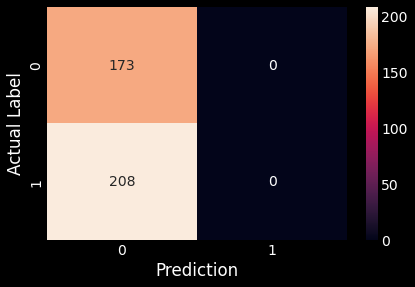

In [41]:
# GENERATING CONFUSION MATRIX (nicely)
sns.heatmap(cf_matrix,annot=True,fmt="d")
plt.xlabel('Prediction')
plt.ylabel('Actual Label')
plt.show()

# Here, it is seen that the model predicts all instances as 0 (Non-Disaster)
# The trained model is not very accurate

In [37]:
# Obtaining overall test set accuracy
y_prediction = np.argmax(y_predict, axis=1)
test_accuracy = sum(y_prediction == y_true)/len(y_true)
print('Test set accuracy:', round(test_accuracy, 2)*100, '%')

# The accuracy is quite low, less than 50%

Test set accuracy: 45.0 %


In [39]:
# Import library for Classification Report
from sklearn.metrics import classification_report

In [38]:
# GENERATING CLASSIFICATION REPORT
c_report = classification_report(y_test, y_prediction)
print(c_report)

              precision    recall  f1-score   support

           0       0.45      1.00      0.62       173
           1       0.00      0.00      0.00       208

    accuracy                           0.45       381
   macro avg       0.23      0.50      0.31       381
weighted avg       0.21      0.45      0.28       381



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Here lists the possible reasons contributing to the low model accuracy:

1.   CNN model is not well-formed (could do with more layers)
2.   Low amount of epochs used in training
3.   Relatively high batch size used for training
4.   Not enough training data used

**SAVING THE MODEL AND WEIGHTS**

In [31]:
model_structure = model.to_json()
with open("cnn_model.json", "w") as json_file:
  json_file.write(model_structure)
model.save_weights("cnn_weights.h5")

**TESTING ON REAL WORLD TWEETS:**

*Three disaster and three non-disaster tweets used*

In [32]:
disaster_tweet1 = """Heavy rain caused flash floods in the Klang Valley this evening.
The KL Fire & Rescue Department says water levels are as high as 1.5m in Lebuh Ampang,
Jalan Raja Alang and Jalan Gurney."""
# Soure: https://twitter.com/newsbfm/status/1304015400745594880?lang=en

disaster_tweet2 = """The downpour also caused the River of Life to overflow,
resulting in floods in the surrounding Masjid Jamek and Dataran Merdeka areas."""
# Soure: https://twitter.com/newsbfm/status/1304015400745594880?lang=en

disaster_tweet3 = """A magnitude 2.4 #Earthquake has occurred this afternoon
at 1:01pm, with an epicentre near Leongatha in Victoria. Two felt reports,
but no impacts reported. If you require VICSES assistance, call 132 500. 
For more: http://earthquakes.ga.gov.au"""
# Source: https://twitter.com/vicsesnews/status/1522068265329205248

nondisaster_tweet1 = """Chinese government-linked hackers have tried to steal
sensitive data from some three dozen manufacturing and technology firms in the US, 
Europe and Asia, security researchers said Wednesday."""
# Soure: https://twitter.com/CNN/status/1521778782843121675?cxt=HHwWlsC5obDvuJ4qAAAA

nondisaster_tweet2 = """NYPD overtime projected to surpass allotted budget by
$142M+ in 2022 amid 'unprecedented' crime climate"""
# Soure: https://twitter.com/FoxNews/status/1522120173913837569?cxt=HHwWgsC4-fmO1J8qAAAA

nondisaster_tweet3 = """Audio obtained by @jmartNYT  and @alexburnsNYT
reveals Republican House Leader Kevin McCarthy called Trump's behavior on
January 6 "atrocious and totally wrong."""
# Soure: https://twitter.com/CNN/status/1522004889940992009

test_tweets = [disaster_tweet1, disaster_tweet2, disaster_tweet3, nondisaster_tweet1, nondisaster_tweet2, nondisaster_tweet3]

In [33]:
n = 0;

for each_testtweet in test_tweets:
  n = n+1

  vec_list = tokenize_and_vectorize([(1, each_testtweet)]) # Tokenize and vectorize tweet
  test_vec_list = pad_trunc(vec_list, maxlen) # Standardize data length
  test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen,embedding_dims)) 
  
  y_predict = model.predict(test_vec) # Predicting the model

  print('Tweet no.', n, ':')
  print('------------------')
  print(each_testtweet)
  print('------------------')
  print('==> Value predicted for tweet' ,n, ':', y_predict)
  if y_predict < 0.5:
    print('==> Prediction: Class 0, Non-Disaster')
  else:
    print('==> Prediction: Class 1, Disaster')
  print('\n')

  # Surprisingly, the model manages to correctly identify these tweets
  # And classified them rightly

Tweet no. 1 :
------------------
Heavy rain caused flash floods in the Klang Valley this evening.
The KL Fire & Rescue Department says water levels are as high as 1.5m in Lebuh Ampang,
Jalan Raja Alang and Jalan Gurney.
------------------
==> Value predicted for tweet 1 : [[0.9811138]]
==> Prediction: Class 1, Disaster


Tweet no. 2 :
------------------
The downpour also caused the River of Life to overflow,
resulting in floods in the surrounding Masjid Jamek and Dataran Merdeka areas.
------------------
==> Value predicted for tweet 2 : [[0.9870095]]
==> Prediction: Class 1, Disaster


Tweet no. 3 :
------------------
A magnitude 2.4 #Earthquake has occurred this afternoon
at 1:01pm, with an epicentre near Leongatha in Victoria. Two felt reports,
but no impacts reported. If you require VICSES assistance, call 132 500. 
For more: http://earthquakes.ga.gov.au
------------------
==> Value predicted for tweet 3 : [[0.7689233]]
==> Prediction: Class 1, Disaster


Tweet no. 4 :
------------